NEURAL MACHINE TRANSLATION WITH TRANSFORMER
Dịch các câu từ tiếng Anh sang tiếng Việt sử dụng mô hình Transformer

Ở các bài tập trước, chúng ta đã giải quyết bài toán dịch máy bằng cách sử dụng mô hình Sequence-to-Sequence (Seq2Seq) cùng với cơ chế Attention. Nếu như mô hình Seq2Seq cho khả năng dịch thuật còn hạn chế, thì cơ chế Attention đã cải thiện phần nào hiệu năng thông qua việc tập trung sự chú ý vào các vùng chứa thông tin quan trọng trong câu. Tuy nhiên, chúng ta mới chỉ thực nghiệm cơ chế Attention bằng cách gắn thêm một/một số lượng Attention Head vào mô hình để gán trọng số cho các đặc trưng được trích xuất từ các lớp trước đó thông qua mạng RNN. Vậy, liệu chúng ta có thể thay thế tất cả các lớp CNN/RNN trước đó thành các lớp kiến trúc Attention hay không? Và nếu làm như vậy thì có giúp mô hình dịch máy học tốt hơn hay không?

Câu trả lời đã được công bố trong công trình ["Attention is All you Need"](https://proceedings.neurips.cc/paper_files/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html) của Ashish Vaswani và cộng sự, năm 2017, giới thiệu về kiến trúc Transformer.
Transformer là một kiến trúc mạng học sâu mà ở đó các lớp CNN hay RNN được thay thế bằng các mô-đun self-attention. Cơ chế self-attention cho phép mô hình Transformer truyền tải thông tin một cách dễ dàng qua các chuỗi đầu vào. Hình 1 dưới đây thể hiện sự khác biệt về kiến trúc mô hình giữa RNN+Attention và Transformer.

Lưu ý: Nên thay đổi runtime sang GPU runtime để quá trình huấn luyện có thể nhanh hơn.

<table>
<tr>
  <th> Mô hình <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention</a></th>
  <th>Một lớp Transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

In [19]:
# @title Khởi tạo các hàm và lớp cần thiết dựa trên các code trước đây
# import from custom utils.py
# from utils import data_preprocessing, Translator, evaluate


from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers , activations , models , preprocessing , utils
import pandas as pd
from keras.models import load_model, Model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import random

from sklearn.model_selection import train_test_split

def masked_loss(label, pred):
    mask = tf.argmax(label, axis=-1) != 0
    loss_object = tf.keras.losses.CategoricalCrossentropy(
        from_logits=False, reduction='none')
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.argmax(label, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

def fix_random_seed(seed_value = 42):
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

def data_preprocessing(lines):
    eng_train_lines = list()
    vie_train_lines = list()

    eng_val_lines = list()
    vie_val_lines = list()

    eng_full_lines = list()
    vie_full_lines = list()

    train_data, val_data = train_test_split(lines, test_size=0.1)


    eng_train_lines = list(train_data.eng)
    vie_train_lines = [ '<START> ' + line_vie + ' <END>'  for line_vie in train_data.vie]

    eng_val_lines = list(val_data.eng)
    vie_val_lines = [ '<START> ' + line_vie + ' <END>'  for line_vie in val_data.vie]

    eng_full_lines = eng_train_lines + eng_val_lines
    vie_full_lines = vie_train_lines + vie_val_lines

    eng_tokenizer = preprocessing.text.Tokenizer()
    eng_tokenizer.fit_on_texts( eng_full_lines )

    tokenized_full_eng_lines = eng_tokenizer.texts_to_sequences( eng_full_lines )
    tokenized_train_eng_lines = eng_tokenizer.texts_to_sequences( eng_train_lines )
    tokenized_val_eng_lines = eng_tokenizer.texts_to_sequences( eng_val_lines )
    max_input_length = np.array( [len( token_seq ) for token_seq in tokenized_full_eng_lines] ).max()

    vie_tokenizer = preprocessing.text.Tokenizer()
    vie_tokenizer.fit_on_texts( vie_full_lines )
    tokenized_full_vie_lines = vie_tokenizer.texts_to_sequences( vie_full_lines )
    tokenized_train_vie_lines = vie_tokenizer.texts_to_sequences( vie_train_lines )
    tokenized_val_vie_lines = vie_tokenizer.texts_to_sequences( vie_val_lines )
    max_output_length = np.array( [len( token_seq ) for token_seq in tokenized_full_vie_lines] ).max()

    padded_train_eng_lines = preprocessing.sequence.pad_sequences( tokenized_train_eng_lines, maxlen=max(max_input_length, max_output_length), padding='post' )
    encoder_train_input_data = np.array( padded_train_eng_lines )

    padded_val_eng_lines = preprocessing.sequence.pad_sequences( tokenized_val_eng_lines, maxlen=max(max_input_length, max_output_length) , padding='post' )
    encoder_val_input_data = np.array( padded_val_eng_lines )

    eng_word_dict = eng_tokenizer.word_index
    num_eng_tokens = len( eng_word_dict )+1

    print( 'Độ dài lớn nhất của English là {}'.format( max_input_length ))
    print( 'Kích thước dữ liệu của Encoder  -> {}'.format( encoder_train_input_data.shape ))
    print( 'Số lượng English tokens = {}'.format( num_eng_tokens))



    # sử dụng pad_sequences để cố định kích thước output của decoder
    padded_train_vie_lines = preprocessing.sequence.pad_sequences( tokenized_train_vie_lines, maxlen=max(max_input_length, max_output_length) , padding='post' )
    decoder_train_input_data = np.array( padded_train_vie_lines )

    padded_val_vie_lines = preprocessing.sequence.pad_sequences( tokenized_val_vie_lines, maxlen=max(max_input_length, max_output_length) , padding='post' )
    decoder_val_input_data = np.array( padded_val_vie_lines )

    vie_word_dict = vie_tokenizer.word_index
    num_vie_tokens = len( vie_word_dict )+1


    print( 'Độ dài lớn nhất của tiếng việt là {}'.format( max_output_length ))
    print( 'kích thước dữ liệu đầu vào của Decoder -> {}'.format( decoder_train_input_data.shape ))
    print( 'Số lượng Vietnamese tokens = {}'.format( num_vie_tokens))



    input_decoder_target_data = list()

    # TODO: chúng ta sẽ loại bỏ '<START> ' đầu tiên của các dòng trong biến `tokenized_vie_lines`
    # và thêm vào `input_decoder_target_data`

    
    for token_seq in tokenized_train_vie_lines:
        input_decoder_target_data.append( token_seq[ 1 : ] )
        # input_decoder_target_data.append( token_seq[ 1 : ] )
    

    padded_vie_lines = preprocessing.sequence.pad_sequences(input_decoder_target_data , maxlen=max_output_length, padding='post' )
    onehot_vie_lines = utils.to_categorical( padded_vie_lines , num_vie_tokens )
    decoder_target_data = np.array( onehot_vie_lines )
    print( 'Decoder target data shape -> {}'.format( decoder_target_data.shape))

    map_vie_i2w = {val: key for key, val in vie_word_dict.items()}
    val_target = [[[map_vie_i2w[i] for i in line[1:-1]]] for line in tokenized_val_vie_lines]
    return (encoder_train_input_data, decoder_train_input_data, decoder_target_data), (encoder_val_input_data,  decoder_val_input_data, val_target), \
                    (eng_word_dict, vie_word_dict), (num_eng_tokens, num_vie_tokens), (eng_tokenizer, vie_tokenizer), (max_input_length, max_output_length)

def positional_encoding(length, depth):
    depth = depth/2
    # TODO: `angle` sẽ được tính thông qua công thức trên
    # với các input là `depth` và `length`

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
    angle = 1 / (10000**depths)         # (1, depth)
    angle = positions * angle      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle), np.cos(angle)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()

        self.mha  = None # MultiHeadAttention
        self.layernorm = None
        self.add = None

        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()

        self.seq = None # nên `tf.keras.Sequential` để chứa 2 lớp `Dense`
        self.add = None
        self.layer_norm = None
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                dff, vocab_size, dropout_rate=0.1):
      super().__init__()

      self.d_model = d_model
      self.num_layers = num_layers

      self.pos_embedding = PositionalEmbedding(
          vocab_size=vocab_size, d_model=d_model)

      self.enc_layers = [
          EncoderLayer(d_model=d_model,
                      num_heads=num_heads,
                      dff=dff,
                      dropout_rate=dropout_rate)
          for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(dropout_rate)
    def compute_output_shape(self, input_shape):
        return [None, None, self.d_model]

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                *,
                d_model,
                num_heads,
                dff,
                dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.

        return x

class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
                dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                        dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

class Translator:

    def __init__(self, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.0, vie_word_dict=None, tokenizers=None, loss = masked_loss):
        fix_random_seed()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation=tf.keras.activations.softmax)

        self.eng_tokenizer = tokenizers[0]
        self.vie_tokenizer = tokenizers[1]

        self.d_model = d_model
        self.map_vie_i2w = {val: key for key, val in vie_word_dict.items()}
        self.vie_word_dict = vie_word_dict
        self.loss = loss


    def build(self):
        encoder_inputs = tf.keras.layers.Input(shape=( None,))
        decoder_inputs = tf.keras.layers.Input(shape=( None,))

        context = self.encoder(encoder_inputs)  # (batch_size, context_len, d_model)

        output = self.decoder(decoder_inputs, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        output = self.final_layer(output)  # (batch_size, target_len, target_vocab_size)

        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy.
            del output._keras_mask
        except AttributeError:
            pass

        self.model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )


    # Load mô hình từ file
    def load(self, model_file):
        self.model = load_model(model_file)

    # Lưu mô hình hiện tại xuống file
    def save(self, model_file):
        self.model.save(model_file)

    # Tóm tắt kiến trúc mạng
    def summary(self):
        self.model.summary()

    # Thử nghiệm mô hình với dữ liệu ảnh đầu vào
    def predict(self, x_test):
        return self.model.predict(x_test)

    def train(self, encoder_input_data , decoder_input_data, decoder_target_data):
        # Các hyper-parameter ở đây được chỉnh để có thể so sánh với mô hình trước.
        # Nếu muốn, các bạn có thể tinh chỉnh để đạt hiệu suất cao hơn.
        learning_rate = CustomSchedule(self.d_model)
        # print(learning_rate)
        optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                        epsilon=1e-9)
        self.model.compile(
                loss=self.loss,
                optimizer=optimizer,
                metrics=[masked_accuracy],
                )
        self.model.fit([encoder_input_data , decoder_input_data], decoder_target_data, batch_size=8, epochs=12)

    def translate(self, input, return_attention=False):
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        input = tf.convert_to_tensor(input, dtype=tf.int64)

        start, end = self.vie_word_dict['start'], self.vie_word_dict['end']
        output_array = output_array.write(0, [start])

        for i in tf.range(max_output_length):
            output = tf.transpose(output_array.stack())
            predictions = self.model([input, output], training=False)

            # Select the last token from the `seq_len` dimension.

            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.
            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            if predicted_id[0] == end or predicted_id[0]==0:
                break

            output_array = output_array.write(i+1, predicted_id[0])
        output = tf.transpose(output_array.stack())
        # print(output)
        text = [self.map_vie_i2w.get(i, '') for i in output[0].numpy()[1:]]  # Shape: `()`.
        if return_attention:
            self.model([input, output], training=False)
            attention_weights = self.decoder.last_attn_scores
            attention_heads = tf.squeeze(attention_weights, 0)
            return text, attention_heads
        return text

    def plot_attention(self, text, **kwargs):
        assert isinstance(text, str)

        input = self.eng_tokenizer.texts_to_sequences([text])
        input = preprocessing.sequence.pad_sequences(input, maxlen=max_input_length , padding='post' )
        output, attention = self.translate(input, return_attention=True)
        attention_weights = tf.concat(attention, 0)
        context = text.split()

        for i in range(len(attention_weights)):
            attention = attention_weights[i][:, :len(context)]
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(1, 1, 1)

            ax.matshow(attention, cmap='viridis', vmin=0.0)

            fontdict = {'fontsize': 14}

            ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
            ax.set_yticklabels([''] + output, fontdict=fontdict)

            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

            ax.set_ylabel('Output text')
            ax.set_xlabel(f'Head {i}')



class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

def evaluate(model, encoder_val_input_data, val_target, num_sample=None):
    num_sample = encoder_val_input_data.shape[0] if num_sample==None else num_sample

    predict_translation = []
    eng_sentence = []

    for i in tqdm(range( num_sample ) ):
        decoded_translation = model.translate(encoder_val_input_data[ i ][None,...])
        eng_sentence.append(encoder_val_input_data[ i ])
        predict_translation.append( decoded_translation )


    predict = [f for f in predict_translation]

    references = val_target[:num_sample]
    candidates = predict
    score = corpus_bleu(references, candidates, weights=(0.5, 0.5))
    print('\nGiá trị bleu score là', score)

In [20]:
# import các thư viện cần thiết
import os
import random
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import load_model, Model
from keras import layers , activations , models , preprocessing , utils
from tensorflow.keras import layers, activations, models, preprocessing, utils
fix_random_seed()

In [21]:
lines = None
lines = pd.read_table('./data/vie.txt' , names=['eng' , 'vie' , 'c' ] )
lines = lines.drop(['c'] , axis=1 )[0:5000]
lines.tail()

,eng,vie
4995,Who's your favorite movie star?,Ngôi sao điện ảnh mà bạn yêu thích là ai thế?
4996,Who's your favorite movie star?,Ngôi sao điện ảnh mà bạn yêu thích là ai vậy?
4997,Why aren't you in your uniform?,Tại sao bạn không mặc đồng phục?
4998,Will he be coming this evening?,Tối nay anh ấy có đến không?
4999,Will he be coming this evening?,Tối nay ông ấy có đến không?


In [22]:
# from utils import data_preprocessing
train_data, val_data, word_dict, num_tokens, tokenizers, max_length = data_preprocessing(lines)

(encoder_train_input_data, decoder_train_input_data, decoder_target_data) = train_data
(encoder_val_input_data,  decoder_val_input_data, val_target) = val_data
(eng_word_dict, vie_word_dict), (num_eng_tokens, num_vie_tokens) = word_dict, num_tokens
(eng_tokenizer, vie_tokenizer), (max_input_length, max_output_length) = tokenizers, max_length


Độ dài lớn nhất của English là 9
Kích thước dữ liệu của Encoder  -> (4500, 17)
Số lượng English tokens = 2451
Độ dài lớn nhất của tiếng việt là 17
kích thước dữ liệu đầu vào của Decoder -> (4500, 17)
Số lượng Vietnamese tokens = 1861
Decoder target data shape -> (4500, 17, 1861)


In [23]:
num_layers = 2
d_model = 64
dff = 128
num_heads = 2
dropout_rate = 0.1

## Khởi tạo và huấn luyện mô hình với cài đặt mặc định

In [24]:
alpha=Translator(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=num_eng_tokens,
    target_vocab_size=num_vie_tokens,
    dropout_rate=dropout_rate,
    vie_word_dict=vie_word_dict, tokenizers=tokenizers)


alpha.build()

alpha.train(encoder_train_input_data , decoder_train_input_data, decoder_target_data)
evaluate(alpha, encoder_val_input_data, val_target)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ke

Epoch 1/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - loss: 7.0444 - masked_accuracy: 0.0774
Epoch 2/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5.0813 - masked_accuracy: 0.2098
Epoch 3/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4.2994 - masked_accuracy: 0.3042
Epoch 4/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 3.7259 - masked_accuracy: 0.3768
Epoch 5/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.2775 - masked_accuracy: 0.4287
Epoch 6/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.9109 - masked_accuracy: 0.4749
Epoch 7/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.6388 - masked_accuracy: 0.5034
Epoch 8/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.4103 - masked_accuracy: 0.5317
Epoch 9/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.1245 - masked_accuracy: 0.5740
Epoch 10/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.8979 - masked_accuracy: 0.6081
Epoch 11/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.7080

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
100%|██████████| 500/500 [05:42<00:00,  1.46it/s]


Giá trị bleu score là 0.37976776481967656


## Skip Connections trong Transformer
Trong các mô hình Transformer, chúng ta đều biết rằng các kết nối bỏ qua (skip connections) đóng vai trò quan trọng trong việc duy trì và truyền tải thông tin qua các tầng mạng. Tuy nhiên, câu hỏi đặt ra là điều gì sẽ xảy ra nếu chúng ta thay đổi hoặc loại bỏ các skip connections này?

Trong phần thực nghiệm này, chúng ta sẽ tiến hành hai thí nghiệm khác nhau:
  - Loại bỏ các Skip Connections
  - Thay thế add trong skip connection bằng concatinate

### Loại bỏ các Skip Connections:
Bằng cách loại bỏ hoàn toàn các skip connections, chúng ta sẽ kiểm tra xem sự thiếu vắng của chúng ảnh hưởng như thế nào đến khả năng huấn luyện và hiệu suất của mô hình. Điều này giúp chúng ta hiểu rõ hơn về tầm quan trọng của skip connections trong việc duy trì thông tin và giảm thiểu hiện tượng biến mất gradient trong quá trình huấn luyện.

In [25]:
# TODO: Định nghĩa các lớp có sử dụng skip-connection trong kiến trúc cũ:
# - EtBaseAttention thay thế cho BaseAttention
# - EtCrossAttention thay thế cho CrossAttention
# - EtGlobalSelfAttention thay thế cho GlobalSelfAttention
# - EtCausalSelfAttention thay thế cho CausalSelfAttention,
# - EtFeedForward thay thế cho FeedForward

class EtBaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        ### BEGIN SOLUTION
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        ### END SOLUTION

class EtCrossAttention(EtBaseAttention):
    def call(self, x, context):
        ### BEGIN SOLUTION
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores
        attn_output = self.layernorm(attn_output)
        return attn_output
        ### END SOLUTION

class EtGlobalSelfAttention(EtBaseAttention):
    ### BEGIN SOLUTION
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = attn_output
        x = self.layernorm(x)
        return x
    ### END SOLUTION

class EtCausalSelfAttention(EtBaseAttention):
    def call(self, x):
        ### BEGIN SOLUTION
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = attn_output
        x = self.layernorm(x)
        return x
        ### END SOLUTION

class EtFeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.dff = dff
        self.d_model = d_model
        ### BEGIN SOLUTION
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.layer_norm = tf.keras.layers.LayerNormalization()
        ### END SOLUTION

    def call(self, x):
        ### BEGIN SOLUTION
        return self.layer_norm(self.seq(x))
        ### END SOLUTION

In [26]:
class EtEncoderLayer(EncoderLayer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.self_attention = EtGlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = EtFeedForward(d_model, dff)


class EtEncoder(Encoder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.enc_layers = [
            EtEncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)]

class EtDecoderLayer(DecoderLayer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.causal_self_attention = EtCausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = EtCrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = EtFeedForward(d_model, dff)



class EtDecoder(Decoder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.dec_layers = [
            EtDecoderLayer(d_model=d_model, num_heads=num_heads,
                        dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]


class Eta(Translator):
    def __init__(self, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.0, vie_word_dict=None, tokenizers=None):
        super().__init__(num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate, vie_word_dict, tokenizers)
        self.encoder = EtEncoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

        self.decoder = EtDecoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

eta=Eta(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=num_eng_tokens,
    target_vocab_size=num_vie_tokens,
    dropout_rate=dropout_rate,
    vie_word_dict=vie_word_dict,
    tokenizers=tokenizers)

eta.build()

eta.train(encoder_train_input_data , decoder_train_input_data, decoder_target_data)
evaluate(eta, encoder_val_input_data, val_target)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'et_global_self_attention_2' (of type EtGlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'sequential_95' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'et_feed_forward_4' (of type EtFeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  war

Epoch 1/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - loss: 7.0379 - masked_accuracy: 0.0888
Epoch 2/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.4550 - masked_accuracy: 0.1336
Epoch 3/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.3316 - masked_accuracy: 0.1322
Epoch 4/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5.2470 - masked_accuracy: 0.1292
Epoch 5/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5.1916 - masked_accuracy: 0.1290
Epoch 6/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5.1535 - masked_accuracy: 0.1312
Epoch 7/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5.1155 - masked_accuracy: 0.1314
Epoch 8/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5.0784 - masked_accuracy: 0.1276
Epoch 9/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5.0165 - masked_accuracy: 0.1295
Epoch 10/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 4.9577 - masked_accuracy: 0.1297
Epoch 11/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4.9134

100%|██████████| 500/500 [05:40<00:00,  1.47it/s]


Giá trị bleu score là 0.21608231958379406



/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [27]:
### BEGIN PUBLIC TESTS
for e in eta.encoder.enc_layers:
    assert not any(isinstance(value, tf.keras.layers.Add) for value in e.self_attention.__dict__.values())
    assert not any(isinstance(value, tf.keras.layers.Add) for value in e.ffn.__dict__.values())
### END PUBLIC TESTS

In [28]:
options = {0: 'hiệu suất eta xấp xỉ alpha (không chêch lệch quá 1%)',
           1: 'hiệu suất eta thấp hơn alpha k% (1<k<5)',
           2: 'hiệu suất eta thấp hơn alpha k% (5<=k<10)',
           3: 'hiệu suất eta thấp hơn alpha k% (10<=k<20)',
           4: 'hiệu suất eta thấp hơn alpha trên 20%',
           5: 'eta gần như không học gì (hiệu suất thấp hơn 10%)'}
your_choice = None
# BEGIN SOLUTION
your_choice = 5
# END SOLUTION
print("Theo mình thì: ", options[your_choice])

Theo mình thì:  hiệu suất eta thấp hơn alpha k% (10<=k<20)


### Thay Add trong skip-connection bằng Concatenate
Thông thường, các skip connections được thực hiện bằng cách cộng (add) đầu vào của lớp với đầu ra của lớp đó. Điều này giúp duy trì thông tin và giảm thiểu hiện tượng biến mất gradient trong quá trình huấn luyện. Tuy nhiên, câu hỏi đặt ra là điều gì sẽ xảy ra nếu chúng ta thay thế phép cộng (add) trong các skip connections bằng phép nối (concatenate)?

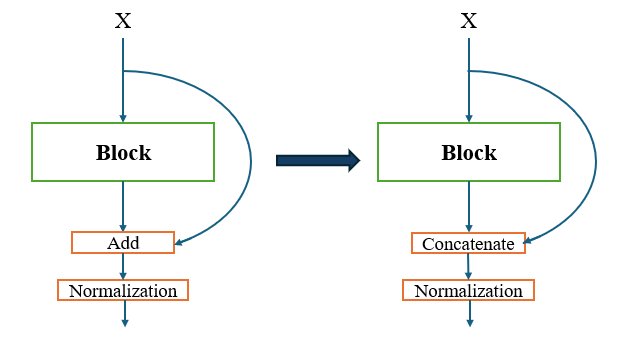

In [33]:
# TODO: Định nghĩa các lớp có sử dụng skip-connection trong kiến trúc cũ bằng cách thay Add bằng Concatenate (sử dụng mudule `concatenate` trong `tf.keras.layers`):
# - EtBaseAttention thay thế cho BaseAttention
# - EtCrossAttention thay thế cho CrossAttention
# - EtGlobalSelfAttention thay thế cho GlobalSelfAttention
# - EtCausalSelfAttention thay thế cho CausalSelfAttention,
# - EtFeedForward thay thế cho FeedForward

class ZBaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        ### BEGIN SOLUTION
        self.mha  = None # MultiHeadAttention
        self.layernorm = None
        self.concatenate = None
        
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.concatenate = tf.keras.layers.Concatenate()
        ### END SOLUTION

class ZCrossAttention(ZBaseAttention):
    def call(self, x, context):
        ### BEGIN SOLUTION
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.concatenate([x, attn_output])
        x = self.layernorm(x)
        return x
        ### END SOLUTION
class ZGlobalSelfAttention(ZBaseAttention):
    def call(self, x):
        ### BEGIN SOLUTION
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.concatenate([x, attn_output])
        x = self.layernorm(x)
        return x

        ### END SOLUTION
class ZCausalSelfAttention(ZBaseAttention):
    def call(self, x):
        ### BEGIN SOLUTION
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.concatenate([x, attn_output])
        x = self.layernorm(x)
        return x

        ### END SOLUTION


class ZFeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.dff = dff
        self.d_model = d_model

        ### BEGIN SOLUTION
        self.seq = None # nên `tf.keras.Sequential` để chứa 2 lớp `Dense`
        self.concatenate = None
        self.layer_norm = None
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.concatenate = tf.keras.layers.Concatenate()
        self.layer_norm = tf.keras.layers.LayerNormalization()
        ### END SOLUTION

    def call(self, x):
        ### BEGIN SOLUTION
        x = self.concatenate([x, self.seq(x)])
        x = self.layer_norm(x)
        return x
        ### END SOLUTION

In [34]:
class ZEncoderLayer(EncoderLayer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.self_attention = ZGlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = ZFeedForward(d_model, dff)


class ZEncoder(Encoder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.enc_layers = [
            ZEncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)]

class ZDecoderLayer(DecoderLayer):
    def __init__(self,
                **kwargs):
        super().__init__(**kwargs)
        self.causal_self_attention = ZCausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = ZCrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = ZFeedForward(d_model, dff)



class ZDecoder(Decoder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.dec_layers = [
            ZDecoderLayer(d_model=d_model, num_heads=num_heads,
                        dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

class Zeta(Translator):
    def __init__(self, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.0, vie_word_dict=None, tokenizers=None):
        super().__init__(num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate, vie_word_dict, tokenizers)
        self.encoder = ZEncoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

        self.decoder = ZDecoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

zeta=Zeta(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=num_eng_tokens,
    target_vocab_size=num_vie_tokens,
    dropout_rate=dropout_rate,
    vie_word_dict=vie_word_dict,
    tokenizers=tokenizers)


zeta.build()

zeta.train(encoder_train_input_data , decoder_train_input_data, decoder_target_data)
evaluate(zeta, encoder_val_input_data, val_target)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:1383: UserWarning: Layer 'z_encoder_6' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Index out of range using input dim 2; input has only 2 dims for '{{node strided_slice_2}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=7, ellipsis_mask=0, end_mask=5, new_axis_mask=0, shrink_axis_mask=0](10474727, strided_slice_2/stack, strided_slice_2/stack_1, strided_slice_2/stack_2)' with input sh

ValueError: Exception encountered when calling ZEncoder.call().

[1mCould not automatically infer the output shape / dtype of 'z_encoder_6' (of type ZEncoder). Either the `ZEncoder.call()` method is incorrect, or you need to implement the `ZEncoder.compute_output_spec() / compute_output_shape()` method. Error encountered:

Index out of range using input dim 2; input has only 2 dims for '{{node strided_slice_2}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=7, ellipsis_mask=0, end_mask=5, new_axis_mask=0, shrink_axis_mask=0](10474786, strided_slice_2/stack, strided_slice_2/stack_1, strided_slice_2/stack_2)' with input shapes: [1000,64], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.[0m

Arguments received by ZEncoder.call():
  • args=('<KerasTensor shape=(None, None), dtype=float32, sparse=False, name=keras_tensor_266>',)
  • kwargs=<class 'inspect._empty'>

In [ ]:
### BEGIN PUBLIC TESTS
x = tf.random.uniform((1, 10, 64))

custom_ffn = ZFeedForward(64,128)
ffn = FeedForward(64,128)

out_ffn = ffn(x)
out_custom_ffn = custom_ffn(x)


assert out_ffn.shape[2]*2 == out_custom_ffn.shape[2]
### END PUBLIC TESTS

In [ ]:
options = {0: 'hiệu suất zeta xấp xỉ alpha (không chêch lệch quá 1%)',
           1: 'hiệu suất zeta thấp hơn alpha k% (1<k<5)',
           2: 'hiệu suất zeta thấp hơn alpha k% (5<=k<10)',
           3: 'hiệu suất zeta thấp hơn alpha k% (10<=k<20)',
           4: 'hiệu suất zeta thấp hơn alpha trên 20%',
           5: 'zeta gần như không học gì (hiệu suất thấp hơn 10%)'}
your_choice = None
# BEGIN SOLUTION
your_choice = 1
# END SOLUTION
print("Theo mình thì: ", options[your_choice])